In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots
from collections import Counter
from matplotlib.lines import Line2D

In [2]:
def mm_norm_col(column):
    return (column - column.min()) / (column.max() - column.min())

In [3]:
## update data
def filter_df(df):
    thresh=8
    age_counts = df.index.get_level_values('age').value_counts()
    ages_greater = list(age_counts[age_counts > thresh].index)
    return df.loc[df.index.get_level_values('age').isin(ages_greater)]

In [4]:
from matplotlib.colors import LinearSegmentedColormap
colors = ['#c7eae5','#008C8D']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

image_ctx = {'image.cmap': 'cubehelix', 'image.interpolation': 'none'}

from matplotlib.colors import LinearSegmentedColormap
# Define the color map
colors = ['#dadaeb','#6a51a3']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

In [5]:
## arrange data
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)

male_df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/longtogeny_males_raw_usage_matrix_v00.parquet').astype(float)
male_df = male_df[keep_syllables]
male_df=filter_df(male_df)
male_df = male_df.query('age<100')

In [6]:
long_df=male_df.copy()
# find first recording per week in the longtogeny dataset
from collections import defaultdict
ages = list(long_df.index.get_level_values('age').unique())
week_entries = defaultdict(list)
for age in ages:
    week, day = str(age).split('.')
    week_entries[week].append(age)

# Find the entry with the lowest day for each week
lowest_day_entries = [min(entries, key=lambda x: float(str(x).split('.')[1])) for entries in week_entries.values()]
long_df = long_df[long_df.index.get_level_values('age').isin(lowest_day_entries)]
long_df = long_df.rename_axis(index={'age': 'age_old'})
long_df['age'] = np.floor(long_df.index.get_level_values('age_old')).astype(int)
long_df.set_index('age',inplace=True, append=True)

In [7]:
# avarage per age or session
m_df= long_df.groupby(['age','uuid','mouse']).mean()
avg_m_df = m_df.groupby(['age']).mean()

# normalize the data
m_norm = mm_norm_col(m_df)
avg_m_norm = mm_norm_col(avg_m_df)

# sort syllable order by the average
syll_sort_m = (
    avg_m_norm.rolling(5, center=True, win_type="exponential")
    .mean(tau=1.5)
    .idxmax()
    .sort_values()
    .index
)

In [8]:
# get labels and data fot plottinh
data_labels = m_norm.index.get_level_values('age').to_numpy()
data = m_norm.to_numpy()

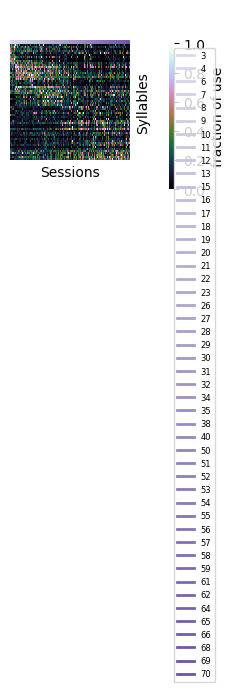

In [9]:
#colors for plotting
cmap2 = cmm
ages = np.unique(data_labels)
colors = np.int_(np.arange(0, 256, 256/len(ages)))
seqmatcolor='cubehelix'

# create age labels colors
lines=[]
counter = Counter(data_labels)
sorted(counter.items())
a=np.array([*counter.values()])

color_mat=[]
n=0
for i,c in enumerate(colors):
    for j in range(a[i]):
        color_mat.append(cmap2(c))

# plot
cg=sns.clustermap(
    data=m_norm[syll_sort_m].T,
    cmap=seqmatcolor, 
    figsize=(2, 2),
    col_colors=color_mat,
    cbar_pos=(1.02, 0.025, 0.025, .73),
    col_cluster=False,
    row_cluster=False,
    yticklabels=False,
    xticklabels=False,
    cbar_kws={'label': 'fraction of use'}, 
    )
cg.ax_row_dendrogram.set_visible(False)
ax = cg.ax_heatmap
ax.set_xlabel('Sessions')
ax.set_ylabel('Syllables')

# legend
for i,c in enumerate(colors):
        lines.append(Line2D([0], [0], color=cmap2(c), lw=2))
plt.legend(handles=lines,labels=list(ages),bbox_to_anchor=(10, 1),loc='upper right',fontsize=6)
plt.show()

In [10]:
c = PlotConfig()
cg.savefig(c.dana_save_path / "fig4"/ 'male_syll_over_time_all_sessions_resampled.pdf', bbox_inches='tight')

In [11]:
# get labels and data fot plottinh
data_labels = avg_m_norm.index.get_level_values('age').to_numpy()
data = m_norm.to_numpy()

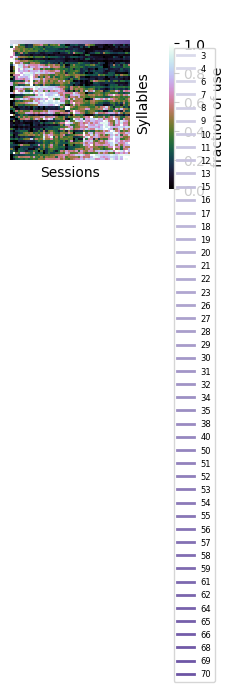

In [12]:
#colors for plotting
cmap2 = cmm
ages = np.unique(data_labels)
colors = np.int_(np.arange(0, 256, 256/len(ages)))
seqmatcolor='cubehelix'

# create age labels colors
lines=[]
counter = Counter(data_labels)
sorted(counter.items())
a=np.array([*counter.values()])

color_mat=[]
n=0
for i,c in enumerate(colors):
    for j in range(a[i]):
        color_mat.append(cmap2(c))

# plot
cg=sns.clustermap(
    data=avg_m_norm[syll_sort_m].T,
    cmap=seqmatcolor, 
    figsize=(2, 2),
    col_colors=color_mat,
    cbar_pos=(1.02, 0.025, 0.025, .73),
    col_cluster=False,
    row_cluster=False,
    yticklabels=False,
    xticklabels=False,
    cbar_kws={'label': 'fraction of use'}, 
    )
cg.ax_row_dendrogram.set_visible(False)
ax = cg.ax_heatmap
ax.set_xlabel('Sessions')
ax.set_ylabel('Syllables')

# legend
for i,c in enumerate(colors):
        lines.append(Line2D([0], [0], color=cmap2(c), lw=2))
plt.legend(handles=lines,labels=list(ages),bbox_to_anchor=(10, 1),loc='upper right',fontsize=6)
plt.show()

In [13]:
c = PlotConfig()
cg.savefig(c.dana_save_path / "fig4"/ 'long_syll_over_time_avg_resampled.pdf', bbox_inches='tight')